# 2. Clustering

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df_preprocessed = pd.read_parquet('../data/ml_dataset_preprocessed.parquet')

The expert has generated four different labels. In order to test that this is reasonable, and also in order to evaluate the labeling of the expert, we will use clustering to study what number of states would be reasonable.

In the clustering, we used the Fourier Transformed voltage and current data. In addition, we will use the sensor_0 data as it seems to be correlated with the states. We will not use sensor_1 ... sensor_5 as they don't seem to include much relevant information for our purpose.

We will perform the cluster on both the full dataset, and on the labeled dataset only

## The full dataset

The full dataset consists of both labeled and unlabeled data. Some data points have been dropped as they contained empty values. See the preprocessing document for more details.

We need to include the _dropna_ method here because the sensor_0 field contains some null values, which we didn't handle during the preprocessing phase. For more details, see the preprocessing document.

In [3]:
df_clustering_full = df_preprocessed.iloc[:, :21].dropna().reset_index(drop=True)

In [4]:
sc = StandardScaler()
df_clustering_full_scaled = pd.DataFrame(sc.fit_transform(df_clustering_full), columns=df_clustering_full.columns)

### K-Means Clustering

Our primary choice of clustering method is K-Means Clustering. To determine the appropriate number of clusters, the "elbow method" will be used. The elbow method is described in detail in [this Wikipedia article](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). WCSS below stands for "within-clusters sum of squares".

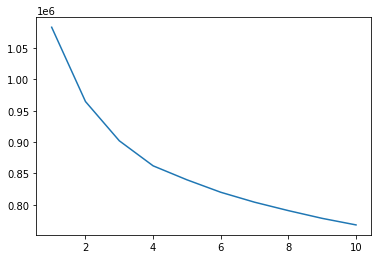

In [5]:
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_clustering_full_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), wcss)
plt.show()

Based on the elbow method, using four labels seems justifiable. It can be argued whether the "elbow" is at two, three or four clusters, but there is nothing plainly wrong with using four labels.

### Hierarchical clustering

In this exercise, we will only use hierarchical clustering to validate (or invalidate) our K-Means Clustering findings. We will inspect the dendrogram of the hierarchical clustering, and use Euclidean distances to determine what the appropriate amount of clusters should be. We will use the Ward variance minimization algorithm. For more information, see [SciPy's documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).

Running this with the full dataset takes some time.

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(df_clustering_full_scaled, method='ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.show()

The dendrogram partially validates our K-Means Clustering findings. The optimal number of clusters could be four, but it may also be two or three.

## The labeled dataset

### K-Means Clustering

In [6]:
df_clustering_labeled = df_preprocessed.dropna(subset=['label', 'sensor_0']).iloc[:, :21].reset_index(drop=True)

In [10]:
sc = StandardScaler()
df_clustering_labeled_scaled = pd.DataFrame(sc.fit_transform(df_clustering_labeled), columns=df_clustering_labeled.columns)

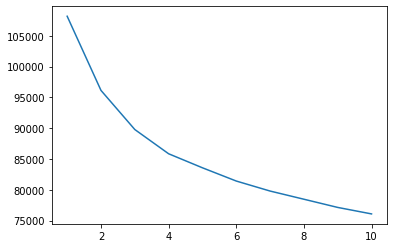

In [8]:
wcss = []
max_clusters = 10
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_clustering_labeled_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), wcss)
plt.show()

### Hierarchical clustering

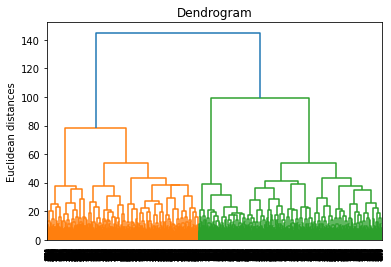

In [9]:
dendrogram = sch.dendrogram(sch.linkage(df_clustering_labeled_scaled, method='ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.show()

Again, the dendrogram validates our previous findings.

## Evaluating the expert labels

As identified previously, the number of lables we have is four while the optimal number seems to be three. We therefore need to investigate which two labels to combine.

In [14]:
expert_labels = df_preprocessed.dropna(subset=['label', 'sensor_0']).reset_index(drop=True).label.astype('int32')

In [15]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(df_clustering_labeled_scaled)

In [25]:
pd.DataFrame({'kmeans': kmeans_labels + 1, 'expert': expert_labels}).groupby('kmeans')['expert'].value_counts(dropna=False).sort_index()

kmeans  expert
1       1          179
        2          219
        3           34
        4          342
2       1          704
        2           66
        3          381
        4           44
3       1         1141
        3          647
        4            1
4       1            5
        2          719
        4          669
Name: expert, dtype: int64

In [17]:
pd.DataFrame({'kmeans': kmeans_labels, 'expert': expert_labels}).groupby('expert')['kmeans'].value_counts(dropna=False)

expert  kmeans
1       2         1141
        1          704
        0          179
        3            5
2       3          719
        0          219
        1           66
3       2          647
        1          381
        0           34
4       3          669
        0          342
        1           44
        2            1
Name: kmeans, dtype: int64

In [23]:
from sklearn.metrics import confusion_matrix

/Users/carl.mattsson/.pyenv/versions/pdn-monitoring/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[1, 2, 3, 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
<ipython-input-24-d7a33fcbe098>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-24-d7a33fcbe098>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


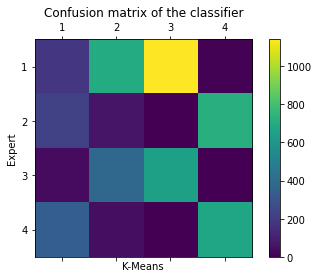

In [24]:
labels = [1, 2, 3, 4]
cm = confusion_matrix(expert_labels, kmeans_labels + 1, labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('K-Means')
plt.ylabel('Expert')
plt.show()

## MISC

In [36]:
df_clustering = df_preprocessed.iloc[:, :21].dropna()
sc = StandardScaler()
df_clustering_scaled = pd.DataFrame(sc.fit_transform(df_clustering), columns=df_clustering.columns)

In [30]:
expert_labels = df_preprocessed.dropna(subset=['label', 'sensor_0']).label.astype('int32')

In [38]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(df_clustering_scaled)

In [40]:
df_clustering_scaled['label_kmeans'] = kmeans_labels

In [47]:
df_compare = df_clustering_scaled.join(expert_labels, how='inner')

In [48]:
df_compare

,voltage_fft_0,voltage_fft_1,voltage_fft_2,voltage_fft_3,voltage_fft_4,voltage_fft_5,voltage_fft_6,voltage_fft_7,voltage_fft_8,voltage_fft_9,...,current_fft_3,current_fft_4,current_fft_5,current_fft_6,current_fft_7,current_fft_8,current_fft_9,sensor_0,label_kmeans,label
9,-0.383374,0.831238,0.391470,-1.976569,-1.638557,-0.346817,1.139077,-0.528768,0.890706,-0.348617,...,-0.472856,-0.705552,-1.064638,0.400340,0.595601,0.776907,0.625127,-1.651146,1,1
10,-0.575821,-1.535943,0.600364,-0.043698,-0.259315,-1.072516,-0.488090,0.240787,0.654750,0.112596,...,-0.096198,-0.012991,-0.778723,-0.646957,-0.376927,0.335396,-2.685308,1.072286,3,2
13,-0.383374,-5.881079,-1.515348,-0.823242,-0.665350,-0.253698,-1.014473,-1.752356,-2.108026,-2.005121,...,-0.856331,-0.871922,-1.513806,-0.253683,0.058653,-1.151852,-0.433248,-0.026147,3,3
29,0.193965,0.900085,-0.712703,-0.556066,0.156851,-0.092163,1.837045,-0.568190,0.405506,1.798257,...,-0.835024,-0.505839,-0.047699,0.972522,0.584984,0.630774,1.569089,-0.392637,2,1
32,0.193965,0.726687,0.818384,0.578545,-0.060449,0.888248,1.339474,-0.170270,-0.075507,-0.082293,...,0.435785,0.677789,-1.169177,0.644546,-1.717456,-1.238224,-0.117769,0.693510,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51540,1.925983,0.540928,1.238880,1.966010,0.241490,0.261113,0.873175,0.836874,0.126996,-0.353434,...,-0.149071,1.087444,-0.126201,0.534946,-0.065285,0.597875,1.700876,1.215103,0,1
51541,-0.768267,-0.614283,0.668058,0.154747,-1.219291,0.036312,-0.601455,-0.519159,-0.411472,-0.552117,...,0.537066,-1.210006,0.132568,-0.385599,-0.678554,0.285805,-0.919607,-0.082178,3,4
51542,-0.575821,-1.211002,0.658908,0.856004,1.946655,-0.810957,0.764321,1.229218,-1.287373,2.280675,...,0.781434,2.119524,-0.750489,1.081301,0.650370,0.606900,0.039443,-0.129340,0,3
51548,-1.153160,0.888908,-1.700323,0.135046,-1.092285,1.050139,-0.746094,-1.105744,0.347808,-1.089614,...,0.246822,-1.458387,-0.185198,0.659318,-0.331191,-0.100336,-0.559401,0.048021,1,2


<ipython-input-51-534b3e0c51ed>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-51-534b3e0c51ed>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


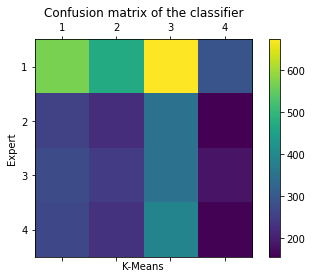

In [51]:
labels = [1, 2, 3, 4]
cm = confusion_matrix(df_compare.label, df_compare.label_kmeans + 1)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('K-Means')
plt.ylabel('Expert')
plt.show()

In [52]:
df_compare.groupby('label_kmeans')['label'].value_counts(dropna=False).sort_index()

label_kmeans  label
0             1        569
              2        257
              3        274
              4        268
1             1        472
              2        224
              3        246
              4        231
2             1        672
              2        349
              3        348
              4        389
3             1        291
              2        156
              3        183
              4        160
Name: label, dtype: int64